In [3]:
from pyspark.sql import SparkSession
import pyspark
from pyspark.sql.functions import col, year, to_date, split
import spacy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os

from sklearn.preprocessing import normalize

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from umap import UMAP

from sklearn.feature_extraction.text import TfidfVectorizer

from nlp_preprocessor import text_preprocessor
from embedders.my_sentence_transformer import MySentenceTransformer

#### Create Spark Session

In [4]:
# Initialize Spark Session with Increased Driver Memory
spark = SparkSession.builder \
    .appName('ReviewsProcessing') \
    .config('spark.driver.memory', '8g') \
    .getOrCreate()

25/12/17 21:46:41 WARN Utils: Your hostname, Safaris-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.1.10.146 instead (on interface en0)
25/12/17 21:46:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/12/17 21:46:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Read in reviews data

In [5]:
reviews_df = spark.read.parquet("yelp_reviews.parquet")

In [6]:
reviews_df.show()

+--------------------+--------------------+--------------------+-----+------+-----+----+--------------------+-------------------+
|           review_id|             user_id|         business_id|stars|useful|funny|cool|                text|               date|
+--------------------+--------------------+--------------------+-----+------+-----+----+--------------------+-------------------+
|KU_O5udG6zpxOg-Vc...|mh_-eMZ6K5RLWhZyI...|XQfwVwDr-v0ZS3_Cb...|  3.0|     0|    0|   0|If you decide to ...|2018-07-07 22:09:11|
|BiTunyQ73aT9WBnpR...|OyoGAe7OKpv6SyGZT...|7ATYjTIgM3jUlt4UM...|  5.0|     1|    0|   1|I've taken a lot ...|2012-01-03 15:28:18|
|saUsX_uimxRlCVr67...|8g_iMtfSiwikVnbP2...|YjUWPpI6HXG530lwP...|  3.0|     0|    0|   0|Family diner. Had...|2014-02-05 20:30:30|
|AqPFMleE6RsU23_au...|_7bHUi9Uuf5__HHc_...|kxX2SOes4o-D3ZQBk...|  5.0|     1|    0|   1|Wow!  Yummy, diff...|2015-01-04 00:01:03|
|Sx8TMOWLNuJBWer-0...|bcjbaE6dDog4jkNY9...|e4Vwtrqf-wpJfwesg...|  4.0|     1|    0|   1|Cu

#### Select only needed columns

In [7]:
reviews_df = reviews_df.select('review_id', 'business_id', 'stars', 'text', 'date')

#### Read in business data

In [8]:
# Read business data
businesses_df = pd.read_json('yelp_dataset/yelp_academic_dataset_business.json', lines=True)

In [23]:
businesses_df.sort_values('categories', ascending=False).head(1000)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
129212,GjQPosKRsjgy6YOClQOUlA,ZooTampa at Lowry Park,1101 W Sligh Ave,Tampa,FL,33604,28.013479,-82.467986,4.0,522,1,"{'BikeParking': 'True', 'GoodForKids': 'True',...","Zoos, Tours, Arts & Entertainment, Hotels & Tr...","{'Monday': '9:30-19:0', 'Tuesday': '9:30-19:0'..."
50433,CU90LyF40t62BRWyzHO29A,Nashville Zoo At Grassmere,3777 Nolensville Pike,Nashville,TN,37211,36.090008,-86.735586,4.0,328,1,"{'GoodForKids': 'True', 'DogsAllowed': 'False'...","Zoos, Hotels & Travel, Event Planning & Servic...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."
118248,sjm9TFtN69KrVsgajcL2Pg,Santa Barbara Zoo,500 Ninos Dr,Santa Barbara,CA,93103,34.419470,-119.668001,4.0,681,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Zoos, Event Planning & Services, Venues & Even...","{'Monday': '9:30-17:0', 'Tuesday': '9:30-17:0'..."
68375,PPVPsVsPGii4xs5trp8LcA,Philadelphia Insectarium & Butterfly Pavilion,8046 Frankford Ave,Philadelphia,PA,19136,40.042510,-75.026367,4.0,57,1,"{'GoodForKids': 'True', 'BusinessParking': '{'...","Zoos, Botanical Gardens, Children's Museums, A...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-17:0', ..."
15785,1YflE3DkiCZGgLnf3paLnA,Forest Park,5595 Grand Dr,Saint Louis,MO,63112,38.639047,-90.284163,5.0,317,1,"{'GoodForKids': 'True', 'BikeParking': 'True',...","Zoos, Arts & Entertainment, Performing Arts, A...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86992,9xMDYRurELJTav7-yq8M7g,Affordable Window Tinting,932 W Grant Rd,Tucson,AZ,85705,32.250631,-110.987620,5.0,88,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Windows Installation, Windshield Installation ...","{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ..."
146996,4nCIZhe_rjFQZ7Ec7FFseA,Glass Doctor of Sewell NJ,"186 Timberlane Rd, Ste B6",Clarksboro,NJ,08020,39.815614,-75.243313,3.5,5,0,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...","Windows Installation, Windshield Installation ...","{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ..."
36313,WsOjr1Jmmr-9TQi5qxKXfA,Jones Window Works,,Tucson,AZ,85701,32.214791,-110.971527,5.0,11,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Windows Installation, Window Washing, Home Ser...","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ..."
25503,rMHHiQErGIWo11fEtIG1Ww,Better View Window Cleaners,6629 N Harran Dr,Tucson,AZ,85704,32.328231,-111.007408,5.0,16,1,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...","Windows Installation, Window Washing, Home Ser...","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ..."


#### Return business id, given business name
Get 'business_id' with highest review count, given business name. We need 'business_id' to filter reviews using id.

In [24]:
# Get reviews of highest review count business
businesses_found = businesses_df[businesses_df['name'].str.lower() == 'zootampa at lowry park']

# Open businesses found
open_businesses_found = businesses_found[businesses_found.is_open == 1].sort_values('review_count', ascending=False)

business_id = open_businesses_found.iloc[0].business_id

In [25]:
business_id

'GjQPosKRsjgy6YOClQOUlA'

In [41]:
business_id = '_ab50qdWOk0DdB6XOrBitw' #'ytynqOUb3hjKeJfRj5Tshw' #acme: '_ab50qdWOk0DdB6XOrBitw'

#### Filter reviews given business id
I only need reviews from a single business in downstream processes. Filter reviews df using business_id

In [42]:
# Retrieve reviews for using business id
business_reviews = reviews_df.filter(col('business_id') == business_id)

In [43]:
business_reviews_df = business_reviews.toPandas()

In [44]:
business_reviews_df.shape

(7673, 5)

In [45]:
# Drop duplicates with same review text
reviews_semantic_df = business_reviews_df.drop_duplicates(subset="text", keep="first").reset_index(drop=True)

In [46]:
reviews_semantic_df.head()

,review_id,business_id,stars,text,date
0,vHLTOsdILT7xgTu7TAWTUQ,_ab50qdWOk0DdB6XOrBitw,5.0,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34
1,I90lP6oPICTkrhCFGQt5tA,_ab50qdWOk0DdB6XOrBitw,5.0,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16
2,469eAl2fB069YTF_B5zW7w,_ab50qdWOk0DdB6XOrBitw,5.0,The fried seafood was extremely hot. Very nice...,2018-08-23 20:58:39
3,aPpHBDs7Jiiq0sb9YutOhQ,_ab50qdWOk0DdB6XOrBitw,5.0,I love this place. I wish my stay was longer s...,2013-06-24 18:07:12
4,k9OG5kA5ebruSx_f1T-P-A,_ab50qdWOk0DdB6XOrBitw,3.0,"Loved the chargrilled oysters! I mean, seriou...",2010-10-06 08:03:20


In [47]:
# Stop the SparkSession
spark.stop()

#### Text Preprocessing
- Denoise the data
- Expand Contractions
- *Remove unwanted characters(ignore, not sure about punctuation yet)
- Replace accented characters
- Remove HTML tags
- Collapse whitespace
- Lower case (Standardize the case)

In [49]:
reviews_semantic_df['text_cleaned'] = reviews_semantic_df.text.apply(text_preprocessor)

#### Extract year for visualizing review counts trends over years
We want to check what years had highest number of reviews for this business.

In [50]:
# extract year from date
reviews_semantic_df['year'] = pd.to_datetime(reviews_semantic_df.date).dt.year

#### Feature Engineering

High-level information:
- Text length(preprocessed text; num of chars)
- Word counts(Count Vectorizer/Tf-Idf/N-grams)
- Average word length

In [51]:
reviews_semantic_df['char_count'] = reviews_semantic_df.text_cleaned.str.len()
reviews_semantic_df['word_count'] = reviews_semantic_df.text_cleaned.str.split().str.len()
reviews_semantic_df['avg_word_length'] = reviews_semantic_df['char_count']/reviews_semantic_df['word_count']

In [52]:
reviews_semantic_df.head(2)

,review_id,business_id,stars,text,date,text_cleaned,year,char_count,word_count,avg_word_length
0,vHLTOsdILT7xgTu7TAWTUQ,_ab50qdWOk0DdB6XOrBitw,5.0,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34,this place has amazing oysters and the best bl...,2016,557,107,5.205607
1,I90lP6oPICTkrhCFGQt5tA,_ab50qdWOk0DdB6XOrBitw,5.0,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16,oh my!! a must try. we had no idea there would...,2016,425,82,5.182927


#### Lemmatize pre-processed reviews (spacy)
We tokenize each review into words, and keep words that carry semantic meaning. We normalize these words into their base form to eliminate redundant meaning and sort of prune our vocabulary.

In [53]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatize(preprocessed_text):
    doc = nlp(preprocessed_text)
    return " ".join([t.lemma_ for t in doc if t.is_alpha and not t.is_stop])

In [54]:
reviews_semantic_df["lemmas"] = reviews_semantic_df["text_cleaned"].apply(lemmatize)

#### Content-based features
- Tf-Idf with ngram_range for phrase-level signals

In [55]:
def build_tfidf(texts):
    min_df = max(3, int(0.01 * len(texts)))

    # TF-IDF Vectorizer
    tv = TfidfVectorizer(
        stop_words="english",
        max_features=8000,
        min_df=min_df,
        max_df=0.75,
        ngram_range=(1,2)
    )

    tfidf_matrix = tv.fit_transform(texts)
    tf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tv.get_feature_names_out())

    return tf_df, tv

In [56]:
reviews_semantic_df.head()

,review_id,business_id,stars,text,date,text_cleaned,year,char_count,word_count,avg_word_length,lemmas
0,vHLTOsdILT7xgTu7TAWTUQ,_ab50qdWOk0DdB6XOrBitw,5.0,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34,this place has amazing oysters and the best bl...,2016,557,107,5.205607,place amazing oyster well bloody mary stay nol...
1,I90lP6oPICTkrhCFGQt5tA,_ab50qdWOk0DdB6XOrBitw,5.0,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16,oh my!! a must try. we had no idea there would...,2016,425,82,5.182927,oh try idea line definitely worth oyster amazi...
2,469eAl2fB069YTF_B5zW7w,_ab50qdWOk0DdB6XOrBitw,5.0,The fried seafood was extremely hot. Very nice...,2018-08-23 20:58:39,the fried seafood was extremely hot. very nice...,2018,530,97,5.463918,fried seafood extremely hot nice taste add sof...
3,aPpHBDs7Jiiq0sb9YutOhQ,_ab50qdWOk0DdB6XOrBitw,5.0,I love this place. I wish my stay was longer s...,2013-06-24 18:07:12,i love this place. i wish my stay was longer s...,2013,193,40,4.825000,love place wish stay long visit food awesome d...
4,k9OG5kA5ebruSx_f1T-P-A,_ab50qdWOk0DdB6XOrBitw,3.0,"Loved the chargrilled oysters! I mean, seriou...",2010-10-06 08:03:20,"loved the chargrilled oysters! i mean, serious...",2010,1277,230,5.552174,love chargrilled oyster mean seriously tasty c...


In [57]:
tf_df, tv = build_tfidf(reviews_semantic_df["lemmas"])

In [58]:
tf_df['chargrilled'].sort_values(ascending=False)

3254    0.454017
2113    0.424600
2232    0.416493
6836    0.400482
1335    0.384393
          ...   
2889    0.000000
2888    0.000000
2887    0.000000
2886    0.000000
7661    0.000000
Name: chargrilled, Length: 7662, dtype: float64

#### Business reviews yearly count

In [59]:
bus_yrly = reviews_semantic_df.year.value_counts().sort_index()
bus_yrly = bus_yrly.reset_index()
bus_yrly.columns = ['year', 'num_reviews']
bus_yrly

,year,num_reviews
0,2006,9
1,2007,15
2,2008,59
3,2009,173
4,2010,240
5,2011,347
6,2012,367
7,2013,535
8,2014,630
9,2015,800


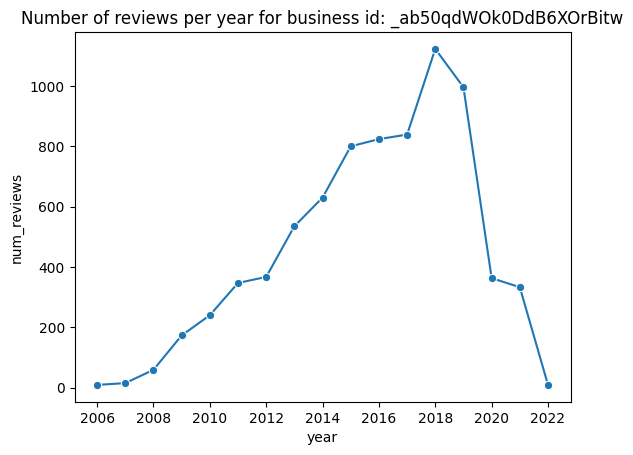

In [60]:
sns.lineplot(x='year', y='num_reviews', marker='o', data=bus_yrly)
plt.title(f"Number of reviews per year for business id: {business_id}")
plt.show()

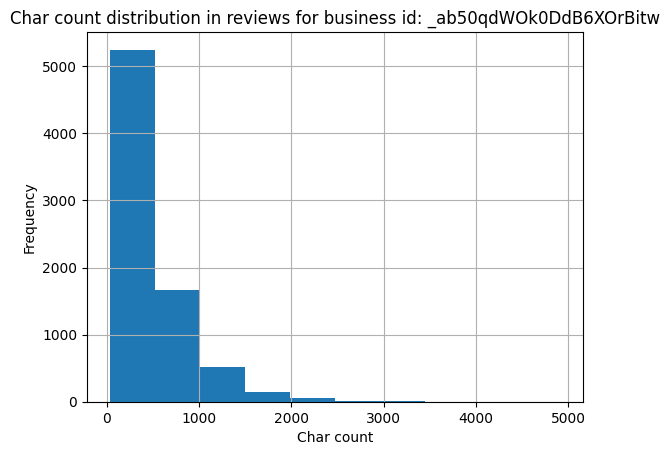

In [61]:
reviews_semantic_df.hist('char_count')
plt.title(f"Char count distribution in reviews for business id: {business_id}")
plt.xlabel('Char count')
plt.ylabel('Frequency')
plt.show()

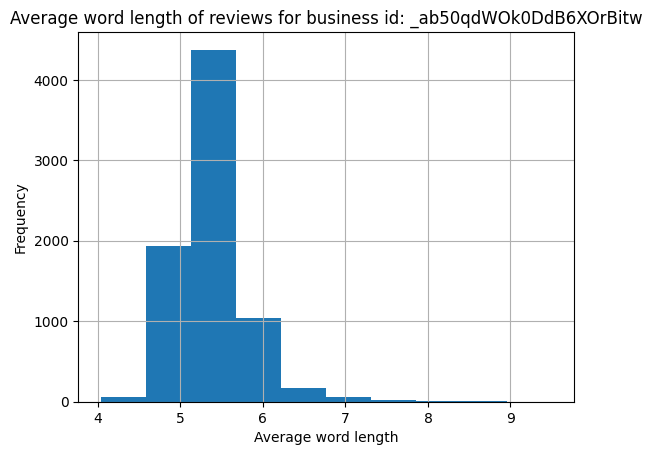

In [62]:
reviews_semantic_df.hist('avg_word_length')
plt.title(f"Average word length of reviews for business id: {business_id}")
plt.xlabel('Average word length')
plt.ylabel('Frequency')
plt.show()

#### Do 1-star rated reviews tend to be longer or shorter?
This is based on cleaned review text not original text.

In [63]:
reviews_semantic_df.head()

,review_id,business_id,stars,text,date,text_cleaned,year,char_count,word_count,avg_word_length,lemmas
0,vHLTOsdILT7xgTu7TAWTUQ,_ab50qdWOk0DdB6XOrBitw,5.0,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34,this place has amazing oysters and the best bl...,2016,557,107,5.205607,place amazing oyster well bloody mary stay nol...
1,I90lP6oPICTkrhCFGQt5tA,_ab50qdWOk0DdB6XOrBitw,5.0,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16,oh my!! a must try. we had no idea there would...,2016,425,82,5.182927,oh try idea line definitely worth oyster amazi...
2,469eAl2fB069YTF_B5zW7w,_ab50qdWOk0DdB6XOrBitw,5.0,The fried seafood was extremely hot. Very nice...,2018-08-23 20:58:39,the fried seafood was extremely hot. very nice...,2018,530,97,5.463918,fried seafood extremely hot nice taste add sof...
3,aPpHBDs7Jiiq0sb9YutOhQ,_ab50qdWOk0DdB6XOrBitw,5.0,I love this place. I wish my stay was longer s...,2013-06-24 18:07:12,i love this place. i wish my stay was longer s...,2013,193,40,4.825000,love place wish stay long visit food awesome d...
4,k9OG5kA5ebruSx_f1T-P-A,_ab50qdWOk0DdB6XOrBitw,3.0,"Loved the chargrilled oysters! I mean, seriou...",2010-10-06 08:03:20,"loved the chargrilled oysters! i mean, serious...",2010,1277,230,5.552174,love chargrilled oyster mean seriously tasty c...


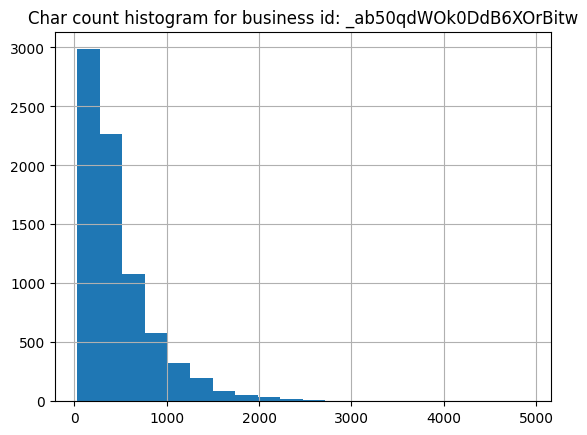

In [64]:
reviews_semantic_df.hist('char_count', bins=20)
plt.title(f"Char count histogram for business id: {business_id}")
plt.show()

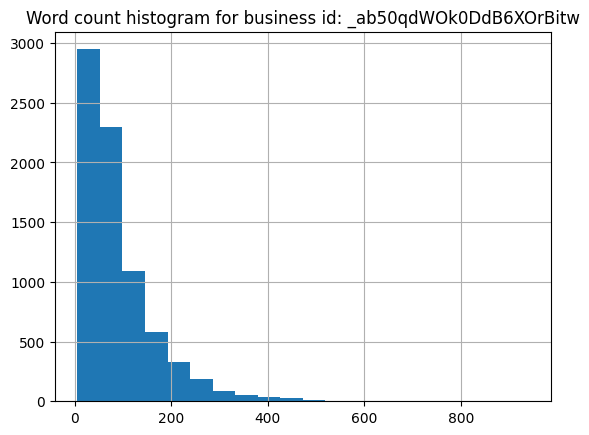

In [65]:
reviews_semantic_df.hist('word_count', bins=20)
plt.title(f"Word count histogram for business id: {business_id}")
plt.show()

Star rating does not corrspond strongly to review text length or word count

### Embeddings
I have evaluated different embedding models(static and contextual), but I will be using 'paraphrase-MiniLM-L3-v2'

In [66]:
my_mpnet_transformer = MySentenceTransformer(model_name='paraphrase-MiniLM-L3-v2')

In [67]:
embs = my_mpnet_transformer.transform_sentences(reviews_semantic_df.text_cleaned)

Since we are interested in clustering aka grouping similar reviews together for theme extraction, we need to normalize/scale embeddings magnitude to 1. 

In [68]:
normalized_embs = normalize(embs)

In [69]:
reviews_semantic_df['normalized_embeddings'] = normalized_embs.tolist()

In [75]:
normalized_embs

array([[ 0.04199314,  0.05851172,  0.09991616, ..., -0.07380617,
         0.01592177,  0.0164871 ],
       [-0.03591486, -0.03511026,  0.06715102, ..., -0.08354747,
        -0.03233955,  0.00769295],
       [-0.03977707,  0.02898106,  0.0420219 , ..., -0.07313942,
         0.01231711, -0.0649834 ],
       ...,
       [ 0.07028382,  0.04205453,  0.06567153, ..., -0.01768606,
        -0.0755658 ,  0.02804619],
       [ 0.04445234,  0.01901945,  0.03214338, ..., -0.0599698 ,
        -0.02434479, -0.00902898],
       [ 0.00736824, -0.00140488,  0.07622293, ..., -0.04837359,
        -0.05880689, -0.00650337]], dtype=float32)

# Save data

In [72]:
path = f'filtered/business_reviews_{business_id}.parquet'
tfidf_path = f'filtered/tfidf_{business_id}.parquet'

# remove folder if it exists (from previous PySpark save)
if os.path.isdir(path):
    shutil.rmtree(path)

# now safely save as a single parquet file
reviews_semantic_df.to_parquet(path, index=False)
tf_df.to_parquet(tfidf_path, index=False)